# Salienc yplot

In [19]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from data.data_loading import get_loaders
import warnings
warnings.filterwarnings("ignore")

loaders = get_loaders('/private/home/krunolp/foci_clean/difFOCI/data', "waterbirds", 1, "ERM")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [32]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

def saliency(img, model1, model2, model3, model4):
    plt.figure(figsize=(10, 10))
    model_names = ['ERM', 'ERM+difFOCI', 'DRO', 'DRO+difFOCI']
    
    for i, model in enumerate([model1, model2, model3, model4]):
        for param in model.parameters():
            param.requires_grad = False
        
        input = img.detach()
        input.unsqueeze_(0)
        input.requires_grad = True
        
        model.eval()

        preds = model(input)
        score, _ = torch.max(preds, 1)
        score.backward()
        sal, _ = torch.max(torch.abs(input.grad[0]), dim=0)
        sal = (sal - sal.min())/(sal.max()-sal.min())

        with torch.no_grad():
            input_img = inv_normalize(input[0])

        plt.subplot(1, 5, i+2, title=model_names[i])
        plt.imshow(sal.numpy(), cmap=plt.cm.hot)
        plt.xticks([])
        plt.yticks([])
        
    plt.subplot(1, 5, 1, title='Original Image')
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()


In [33]:
def prep_model(model_):
    new_keys = [key[8:] if len(key) >= 8 else key for key in model_['model'].keys()]
    model_dict = {new_key: model_['model'][key] for key, new_key in zip(model_['model'].keys(), new_keys)}
    
    try:
        del model_dict['q']
    except:
        pass
    
    model = torchvision.models.resnet50(pretrained=False)
    model.fc = torch.nn.Linear(model.fc.in_features, 2)
    model.load_state_dict(model_dict)
    model.to('cpu');
    return model

In [34]:
model_erm = torch.load("/checkpoint/krunolp/diffusion/badr/nn_save/seed_32469489_12345_12345.best.pt")
model_erm_diffoci = torch.load("/checkpoint/krunolp/diffusion/badr/nn_save/seed_32421138_12345_12345.best.pt")
model_dro = torch.load("/checkpoint/krunolp/diffusion/badr/nn_save/seed_32469225_12345_12345.best.pt")
model_dro_diffoci = torch.load("/private/home/krunolp/foci/exp_runs/seed_32619806_1956_12345_1234.best.pt")

models = [prep_model(model) for model in [model_erm, model_erm_diffoci, model_dro, model_dro_diffoci]]
del model_erm, model_erm_diffoci, model_dro, model_dro_diffoci

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


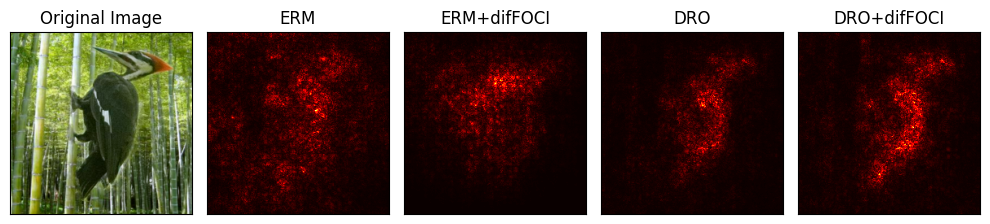

In [67]:
loaders = get_loaders('/private/home/krunolp/foci/datasets/balancing_data', 'waterbirds', 1, 'ERM')
_, x, _, _ = next(iter(loaders["tr"]))
saliency(x.squeeze(), *models)
